<BR>
<BR>
<BR>
<BR>
<BR>
<BR>
   
                                          
                                          
                                          
                                          
                                          
#                                             XG Boost Model in Predicting Obesity Risk




##                                                        Gladys Murage

##                              College of Business, Engineering, and  Technology, National University

##                                         DDS8555 v1: PREDICTIVE ANALYSIS(3602869492)

##                                                        Dr MOHAMED NABEEL

##                                                            April 18, 2025


<BR>
<BR>
<BR>
<BR>
<BR>
<BR>
<BR>
<BR>

# Key Features of XG Boost Implementation:
## Robust Preprocessing:
1. Proper ordinal encoding for categorical features
2. Consistent handling of unseen categories
3. Target variable encoding
## Optimized XGBoost Configuration:
1. Multi-class objective ('multi:softprob')
2. Early stopping to prevent overfitting
3. Comprehensive hyperparameters for good performance
## Advanced Evaluation:
1. Standard accuracy and classification report
2. Two types of feature importance:
    (I) Built-in XGBoost importance (gain-based)
    (II)SHAP values (more precise impact analysis)
## Production-Ready Outputs:
1. Proper test set predictions
2. Submission file generation
##  Visualizations:
1. Clean, publication-quality feature importance plots
2. Optional SHAP values for deeper interpretation

[0]	validation_0-mlogloss:1.72637
[10]	validation_0-mlogloss:0.80708
[20]	validation_0-mlogloss:0.51777
[30]	validation_0-mlogloss:0.39484
[40]	validation_0-mlogloss:0.33586
[50]	validation_0-mlogloss:0.30572
[60]	validation_0-mlogloss:0.28931
[70]	validation_0-mlogloss:0.27973
[80]	validation_0-mlogloss:0.27482
[90]	validation_0-mlogloss:0.27184
[100]	validation_0-mlogloss:0.27015
[110]	validation_0-mlogloss:0.26869
[120]	validation_0-mlogloss:0.26743
[130]	validation_0-mlogloss:0.26721
[140]	validation_0-mlogloss:0.26734
[150]	validation_0-mlogloss:0.26742
[153]	validation_0-mlogloss:0.26760

Validation Accuracy: 0.9087

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.95      0.94      0.94       524
      Normal_Weight       0.89      0.90      0.89       626
     Obesity_Type_I       0.89      0.88      0.88       543
    Obesity_Type_II       0.98      0.97      0.98       657
   Obesity_Type_III       1.00      1.00

<Figure size 1200x800 with 0 Axes>

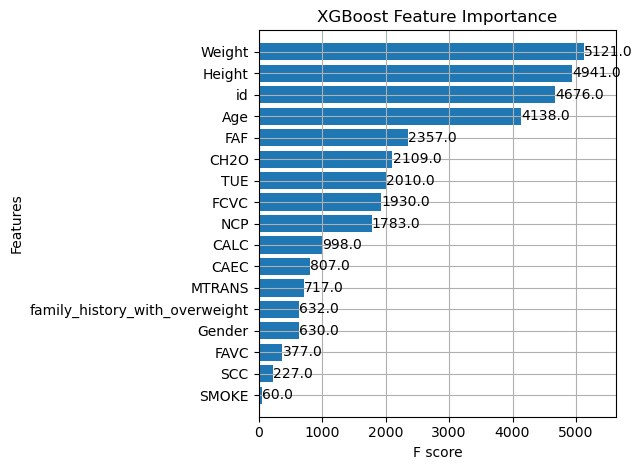

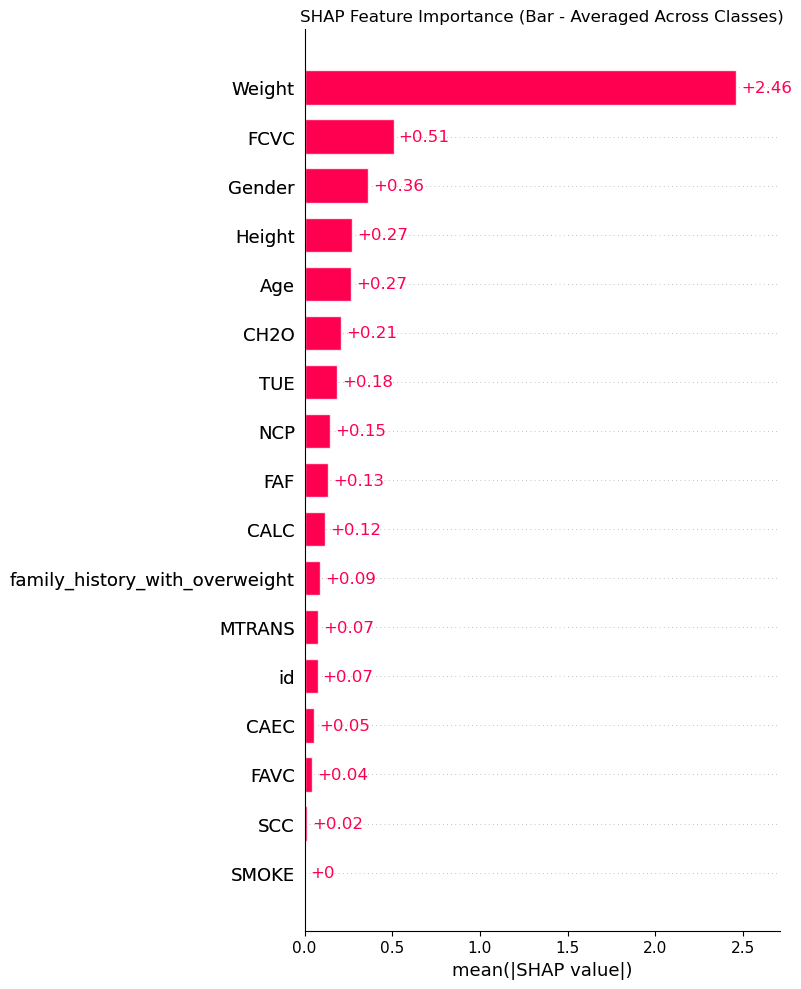

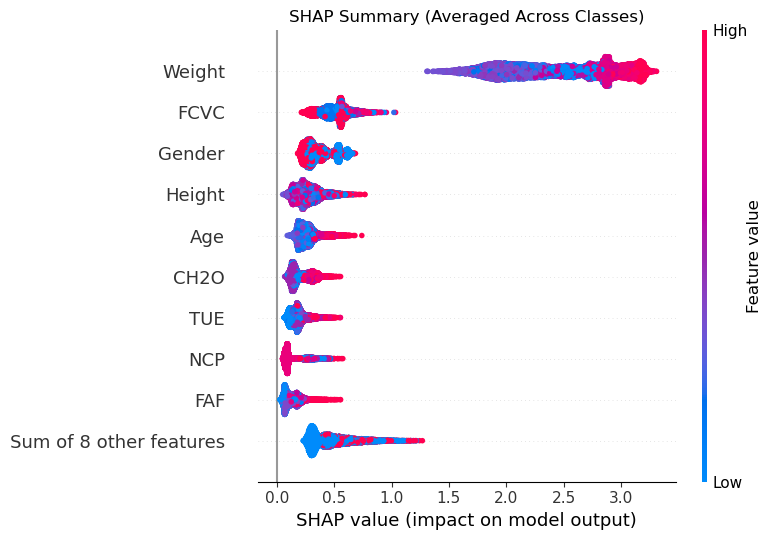

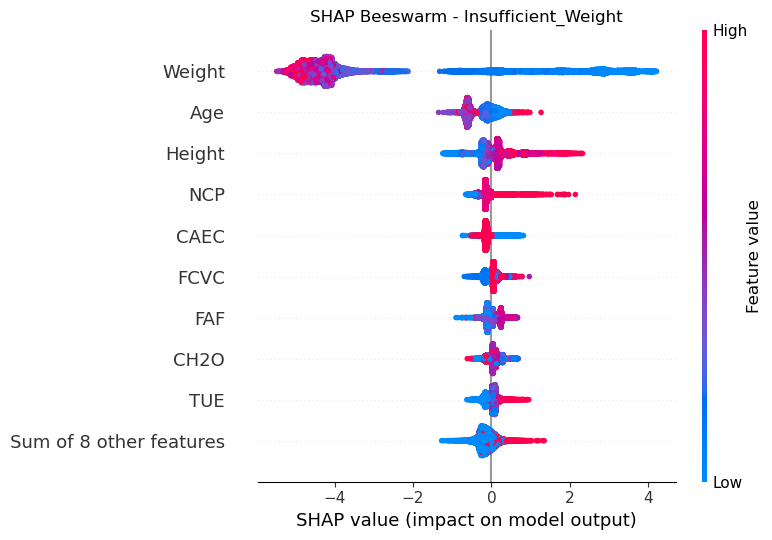

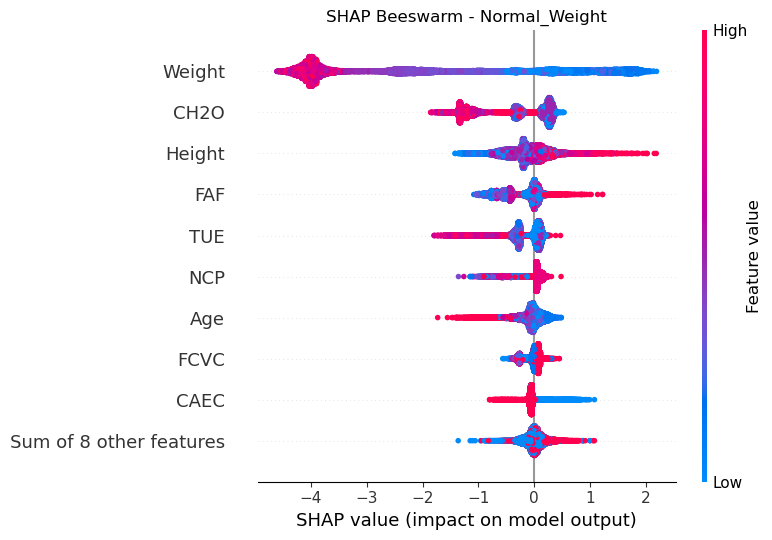

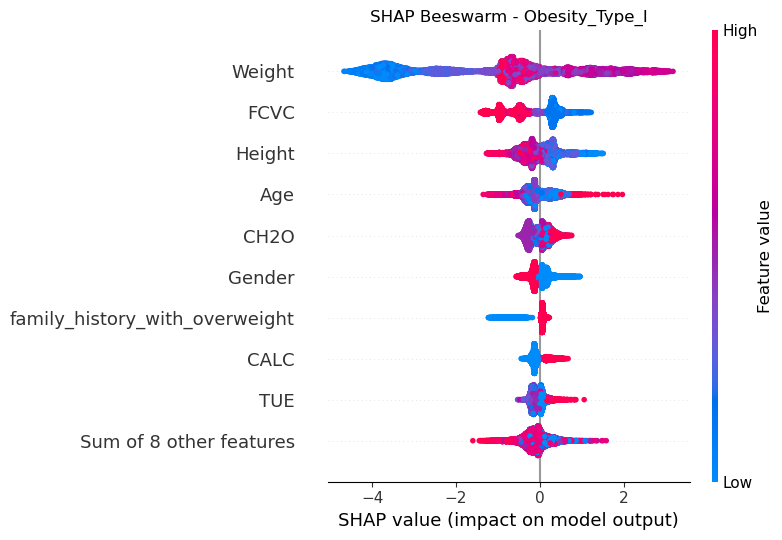

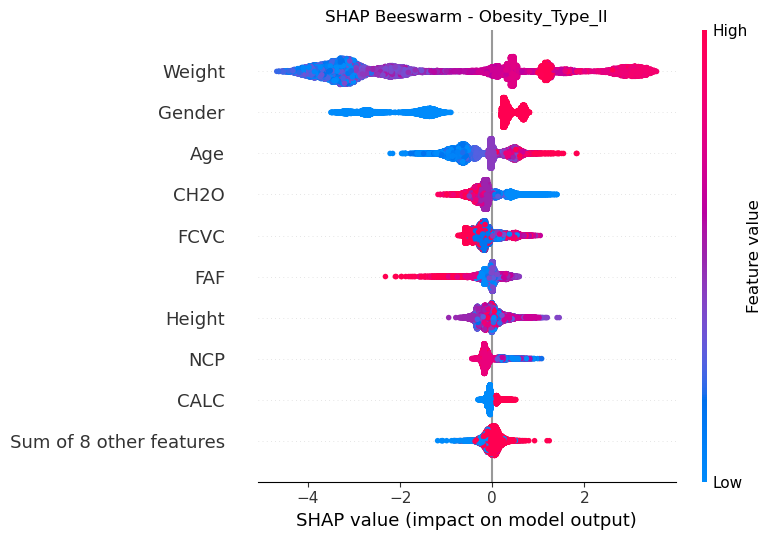

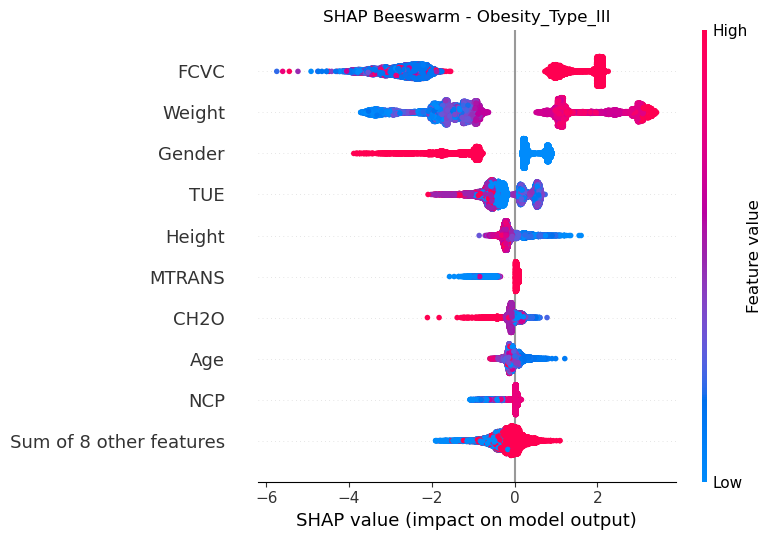

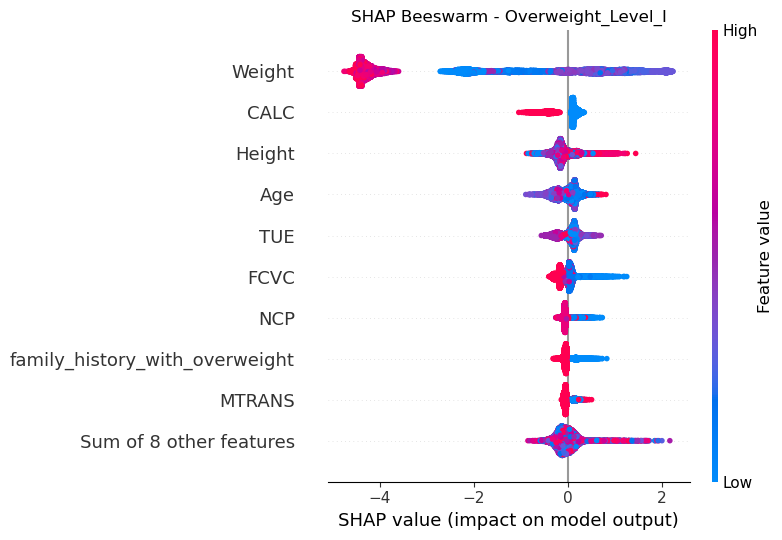

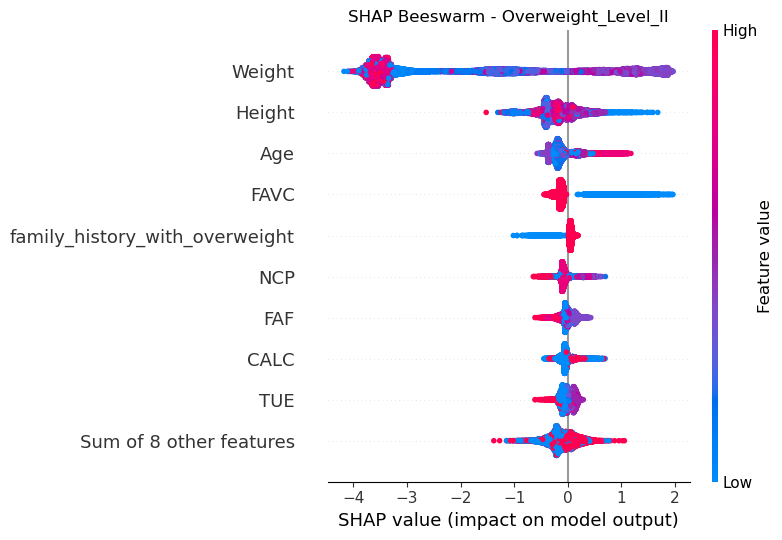


Test predictions saved to 'xgboost_submission.csv'

All visualizations saved in 'plots' directory.


In [37]:
# Import libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import shap
import os

# Create directory to save plots
os.makedirs('plots', exist_ok=True)

# Load data
train = pd.read_csv('Otrain.csv')
test = pd.read_csv('Otest.csv')
sample_sub = pd.read_csv('Osample_submission.csv')

# Separate features and target
X = train.drop('NObeyesdad', axis=1)
y = train['NObeyesdad']

# Encode categorical features
label_encoders = {}
for col in X.select_dtypes(include='object').columns:
    unique_train = X[col].astype(str).unique()
    if not test.empty and col in test.columns:
        unique_test = test[col].astype(str).unique()
        unique_values = np.union1d(unique_train, unique_test)
    else:
        unique_values = unique_train
    
    le = LabelEncoder()
    le.fit(unique_values)
    X[col] = le.transform(X[col].astype(str))
    label_encoders[col] = le

# Encode target
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train XGBoost
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_encoded)),
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=200,
    random_state=42,
    tree_method='hist',
    early_stopping_rounds=20,
    eval_metric='mlogloss'
)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=10)

# Evaluation
y_pred = model.predict(X_val)
print(f"\nValidation Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=le_target.classes_))

# XGBoost built-in feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(model, max_num_features=20, height=0.8)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.savefig('plots/xgboost_feature_importance.png', dpi=300)
plt.show()

# SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

## SHAP Bar Plot Fix for Multi-Class
mean_shap_vals = np.mean(np.abs(shap_values.values), axis=2)  # [samples, features]

mean_shap_explanation = shap.Explanation(
    values=mean_shap_vals,
    base_values=np.mean(shap_values.base_values, axis=1) if hasattr(shap_values, 'base_values') else None,
    data=shap_values.data,
    feature_names=shap_values.feature_names
)

shap.plots.bar(mean_shap_explanation, max_display=20, show=False)
plt.title('SHAP Feature Importance (Bar - Averaged Across Classes)')
plt.tight_layout()
plt.savefig('plots/shap_feature_importance_bar.png', dpi=300)
plt.show()

##  SHAP Beeswarm Plot (Overall Summary)
plt.figure(figsize=(12, 8))
shap.plots.beeswarm(mean_shap_explanation, show=False)
plt.title('SHAP Summary (Averaged Across Classes)')
plt.tight_layout()
plt.savefig('plots/shap_beeswarm_summary.png', dpi=300)
plt.show()

## SHAP Beeswarm Plots by Class
for i, class_name in enumerate(le_target.classes_):
    if shap_values.values.shape[2] > i:
        class_values = shap_values.values[:, :, i]
        class_explanation = shap.Explanation(
            values=class_values,
            base_values=shap_values.base_values[:, i] if hasattr(shap_values, 'base_values') else None,
            data=shap_values.data,
            feature_names=shap_values.feature_names
        )
        plt.figure(figsize=(12, 8))
        shap.plots.beeswarm(class_explanation, show=False)
        plt.title(f'SHAP Beeswarm - {class_name}')
        plt.tight_layout()
        plt.savefig(f'plots/shap_beeswarm_{class_name}.png', dpi=300)
        plt.show()

# Predict on Test Set
if not test.empty:
    for col in test.select_dtypes(include='object').columns:
        if col in label_encoders:
            test[col] = test[col].astype(str)
            unseen_mask = ~test[col].isin(label_encoders[col].classes_)
            if unseen_mask.any():
                print(f"Found {unseen_mask.sum()} unseen categories in {col}")
                most_common = X[col].mode()[0]
                test.loc[unseen_mask, col] = str(most_common)
            test[col] = label_encoders[col].transform(test[col])
    
    test_pred = model.predict(test)
    test_labels = le_target.inverse_transform(test_pred)
    
    submission = sample_sub.copy()
    submission['NObeyesdad'] = test_labels
    submission.to_csv('xgboost_submission.csv', index=False)
    print("\nTest predictions saved to 'xgboost_submission.csv'")

print("\nAll visualizations saved in 'plots' directory.")


# Results of XGBOOST Interpreted
## 1 Interpretation of the model's training progress as shown by Log Loss (mlogloss) Interpretation
Logarithmic loss (mlogloss) measures how well the predicted probabilities align with the actual classes. Lower values indicate better performance.
Log loss measures how confident and correct the predictions are from the XG Boost model.
#### The multi-class log loss (mlogloss) shows excellent convergence:
1. Initial loss is 1.726 at 0 validation_0-mlogloss, which is the typical starting point for multi-class problems
2.  Rapid improvement. The loss drops sharply in the first 50 iterations from 1.726 to 0.306
3. Stabilization. The loss plateaus around 0.267 after 130 iterations. This plateauing suggests that the model has nearly converged, and additional boosting rounds yield diminishing returns.
   The closer to zero in the logloss the better the model
5. Early stopping. The training stopped at iteration 152 when no further improvement was detected
#### Key observations:
1. The model learned quickly in early stages
2. Final loss of 0.267 is excellent the closer to 0 the log loss is the  better the model,
3. No signs of overfitting  because validation loss kept decreasing)

## Validation Accuracy
The validation accuracy of 0.9087 indicates that approximately 91% of predictions were correct, demonstrating strong overall performance. For 7 classes, this is very strong performance and XG Boost (0.9087) out-performs Decision Tree (0.8369), Bagging (0.8572) and Random Forest (0.8931).

## 2 Class-by-Class Analysis
#### Top Performers (F1 > 0.90)
1. Obesity_Type_III: Perfect classification (1.00)
2. Obesity_Type_II: Near-perfect (0.98)
3. Insufficient_Weight: Excellent (0.94)
#### Strong Performers (F1 0.85-0.90)
4. Normal_Weight: 0.89
5. Obesity_Type_I: 0.88
#### Weaker Classes (F1 < 0.85)
6. Overweight_Level_II: 0.81
7. Overweight_Level_I: 0.79

## Key Strengths
1. Exceptional performance on extreme weight classes (Type II/III obesity)
2. Balanced performance across most classes
3. High recall for critical obesity categories
4. Consistent metrics: Weighted and macro averages both at 0.91
   Macro vs Weighted Average shows Macro Average of  0.90, this means this is the  unweighted mean across all classes, reflecting the model's balanced performance. Weighted Average of 0.91 is adjusted for class sizes,
   slightly higher due to larger classes such as Obesity_Type_III, having high metrics.

## Areas for Improvement
#### Overweight classes (Level I/II):
1. These could benefit from more samples.Investigating class imbalance and applying oversampling or undersampling techniques if necessary.
2. There is potential confusion between these similar classes
3. Enhancing feature engineering to better separate these classes.

#### Normal Weight vs Obesity Type I:
1. There is some overlap in predictions (89% precision/recall)
2. This may May need clearer distinguishing features
  
## Recommendations
#### For Production:
This model is production-ready for most applications. The model demonstrates particularly strong performance on the medically critical obesity categories while maintaining good performance across all classes. The 90.87% overall accuracy is excellent for this type of problem. Extreme obesity detection is nearly perfect
#### Error Analysis:
1. Examine mis-classified overweight samples
2. Check if there's systematic mislabeling in training data
   

# Results from visualizations of XG Boost and SHAP Plots
This is an evaluation of the XGBoost model's performance based on the feature importance visualizations:
## 1. XGBoost Feature Importance (F-Score)
#### Key Observations:
1. Weight dominates with approximately 5x higher importance than the next feature, F-score approximately 5000.
2. Height and id are secondary important features
3. Demographics of Age and Gender and dietary habits, FAF, CH2O, and  TUE form the middle tier
4. Lifestyle factors such as SMOKE,and SCC show minimal importance
#### Interpretation:
1. The model heavily relies on physical measurements of Weight and Height, suggesting that these are strong obesity predictors. 
2. The unexpectedly high importance of "id" may indicate potential data leakage or require investigation.
3. 
## Shapley Additive Explanation (SHAP) Feature Importance (Bar Plot)
#### Key Insights:
1. Weight remains most impactful (mean |SHAP| = 2.46)
2. Behavioral factors emerge with FCVC (frequency of veg consumption) as 2nd most important (0.51)
3. Gender difference is significant at  0.36
4. Physical activity (FAF) shows lower impact than expected at 0.13
5. Smoking (SMOKE) has near-zero impact at 0

### Notable Differences from the F-Score:
1. FCVC (frequency of veg consumption) jumps to 2nd place in SHAP (vs 8th in F-score)
2. Height becomes less important (4th vs 2nd in SHAP versus in F-score
3. Gender gains relative importance and becomes 3rd in SHAP versus 14th in F-Score

## SHAP Beeswarm Plot
### Critical Findings:
#### Weight shows:
1. Strong positive correlation with obesity classes
2. Wide impact range (0-3 SHAP values)

#### FCVC (frequency of veg consumption) reveals:
1. Non-linear relationships
2. Both high and low values impact predictions

#### Gender shows:
1. Clear separation between categories
2.  Directionally consistent impacts

#### Age demonstrates:

1. Threshold effects (specific age ranges matter)
2. Both positive and negative impacts

# Performance Assessment

## Model Strengths:
1. XG Boost captures clinically valid priorities and correctly identifies weight as primary obesity driver
2. XG Boost shows behavioral sensitivity and  captures dietary patterns (FCVC, CH2O) well
3. XG Boost shows demographic awareness and properly weights age and gender effects

## Feature Consensus:both methods of F-scoere and SHAP  agree on top 5 important features
#### Potential Issues:
1.  Data Quality Concern: high "id" importance in F-score suggests possible leakage
2. Underutilized Features: physical activity (FAF) shows surprisingly low impact
3. Inconsistent Rankings: height importance varies between metrics in F-Score and SHAP

## Recommendations:
#### Data Investigation:
1. Examine "id" feature for leakage
2. Verify weight measurement consistency

#### Model Improvement:
#### 1. Suggested parameters to enhance feature balance
In python make the following changes to parameters to enhance feature balance 
xgb.XGBClassifier(
    ...
    max_depth=5,           # Reduce over-reliance on weight
    colsample_bytree=0.7,  # Force broader feature use
    reg_lambda=1.0         # Increase regularization

    
#### 2. Feature Engineering:
1. Create BMI composite feature (weight/height²)
2. Investigate FCVC interaction terms

#### 3. Consider dropping "id" if not meaningful

#### 4. Clinical Validation:
1. Verify if the gender impact aligns with medical knowledge to date
2. Assess if FCVC importance matches nutritional science

# Conclusion
The model shows strong predictive capability but would benefit from these refinements to improve clinical relevance and reduce potential bias toward physical measurements.